
# Download kaggle dataset

In [1]:
%%capture
# Set up Kaggle dataset
! kaggle datasets download -d andrewmvd/face-mask-detection
! mkdir face-mask-detection
! unzip face-mask-detection.zip -d face-mask-detection

# Set up Imports

In [2]:
# Model Building
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split

# Data Extraction
from bs4 import BeautifulSoup # This is used to parse through xml files to extract bounding box information
from PIL import Image # Image editing

# Data Visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Working with files and model saves
import os
from pathlib import Path

# Functions to parse xml data and retrieve bounding boxes + labels


> Following code snippet taken from Pytorch FasterRCNN by Daniel and slightly tweaked to match this project

*   def generate_box(obj): Input "object" from xml; Output bounding box
*   def generate_label(obj): Input "object" from xml; Output label


> For fine-tuning pretrained fasterrcnn_resnet50_fpn it requires input tensors and targets:

*   Bounding-boxes of type FloatTensor[N, 4]
*   Labels of type Int64Tensor[N]











In [3]:
# Get Ground Truth Box
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

# Get Ground Truth Label
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect": # Yes, this is how it is labeled in the xml file
        return 2
    return 0 # without_mask

# Use BeautifulSoup to read xml data, all faces stored in objects[]
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        # Bounding boxes for objects
        # In pytorch, the input should be [xmin, ymin, xmax, ymax], WE ARE USING THIS
        # In coco format, bounding box = [xmin, ymin, width, height]
        boxes = []
        labels = []
        for obj in objects:
            boxes.append(generate_box(obj))
            labels.append(generate_label(obj))

        # Convert boxes and labels to tensor objects for fasterrcnn_resnet50_fpn
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        return target

# CREATE DATALOADER

## Create dataset class which is required for torch.utils.data.DataLoader(), this will be a Map-style dataset

*   implements \__getitem__() and \__len__()



In [4]:
class Dataset():
  def __init__(self, indices):
    self.imgs = list(sorted(os.listdir("/content/face-mask-detection/images/")))
    self.labels = list(sorted(os.listdir("/content/face-mask-detection/annotations/")))
    self.indices = indices

  def __getitem__(self, idx):
    # Generate file paths from idx
    img_file = 'maksssksksss'+ str(self.indices[idx]) + '.png'
    label_file = 'maksssksksss'+ str(self.indices[idx]) + '.xml'

    img_path = os.path.join("/content/face-mask-detection/images", img_file)
    label_path = os.path.join("/content/face-mask-detection/annotations", label_file)

    # Load Image
    img = Image.open(img_path).convert("RGB")
    data_transform = transforms.Compose([transforms.ToTensor(), ])
    img = data_transform(img)

    # Generate Label
    target = generate_target(label_path)

    return img, target

  def __len__(self):
    return len(self.indices)

## Create collate function which is required for torch.utils.data.DataLoader()

In [5]:
def collate_fn(batch):
  return tuple(zip(*batch))

## Train/Valid Split

In [6]:
total_imgs = len(list(sorted(os.listdir("/content/face-mask-detection/images/"))))
train_indices, valid_indices = train_test_split(range(total_imgs), test_size=0.3, random_state=1)

## Create train and validation DataLoader() objects

In [7]:
train_dl = torch.utils.data.DataLoader(dataset=Dataset(train_indices),
                                          batch_size=16,
                                          collate_fn=collate_fn)

valid_dl = torch.utils.data.DataLoader(dataset=Dataset(valid_indices),
                                          batch_size=8,
                                          collate_fn=collate_fn)

# Make instance of pretrained Faster R-CNN

In [8]:
def get_model(num_classes):
  model = models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [9]:
model = get_model(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 132MB/s]


# Fine-tune Faster R-CNN model on our dataset

## Create optimizer

In [10]:
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.0005)

## Set Device type

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## LOAD MODEL FROM GDRIVE

In [12]:
model.load_state_dict(torch.load('/content/drive/MyDrive/FaceMaskModel_2.pt'))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Fine-tune

In [13]:
#model.to(device)
num_epochs = 10
len_dataloader = len(train_dl)

for epochs in range(num_epochs):
  model.train()
  i = 0
  epoch_loss = 0
  for imgs, annotations in train_dl:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    loss_dict = model([imgs[0]], [annotations[0]])
    loss = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print(f'Iteration: {i}/{len_dataloader}, Loss: {loss}')
    epoch_loss += loss

  print(epoch_loss)
  torch.save(model.state_dict(),'/content/drive/MyDrive/FaceMaskModel_2.pt')

tensor(6.6571, grad_fn=<AddBackward0>)
tensor(6.0540, grad_fn=<AddBackward0>)
tensor(5.8775, grad_fn=<AddBackward0>)
tensor(5.1328, grad_fn=<AddBackward0>)
tensor(4.7833, grad_fn=<AddBackward0>)
tensor(4.6389, grad_fn=<AddBackward0>)
tensor(4.8245, grad_fn=<AddBackward0>)
tensor(5.8949, grad_fn=<AddBackward0>)
tensor(6.3284, grad_fn=<AddBackward0>)
tensor(5.7672, grad_fn=<AddBackward0>)


In [13]:
for imgs, annotations in valid_dl:
      imgs = list(img.to(device) for img in imgs)
      annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
      break

In [14]:
model.eval()
# Use with torch.no_grad() to prevent memory buildup exceeding colab's limits
with torch.no_grad():
  preds = model(imgs)
preds

[{'boxes': tensor([[339.9093,  44.0722, 351.4452,  56.0165],
          [263.6060,  51.1935, 285.2927,  73.7126],
          [ 28.9816,  46.9613,  47.7015,  66.2901],
          [185.2326,  40.4404, 210.4927,  68.3587],
          [198.3172, 106.0475, 218.9817, 126.0374],
          [ 87.8821,  51.6510, 102.3652,  66.8561],
          [305.5788,  48.6428, 319.6470,  61.7229],
          [367.6719,  49.8323, 384.3093,  69.2289],
          [339.2165,  43.6964, 350.6824,  49.9142],
          [367.9607,  46.3853, 383.4864,  69.9996],
          [264.8950,  51.0341, 283.5847,  69.1275],
          [199.5265, 105.2191, 217.5952, 121.0515],
          [ 87.8799,  49.4098, 104.1935,  67.2993]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]),
  'scores': tensor([0.9854, 0.9705, 0.9699, 0.9661, 0.9287, 0.9018, 0.8941, 0.7681, 0.1028,
          0.0920, 0.0802, 0.0657, 0.0501])},
 {'boxes': tensor([[269.0751,  39.3771, 300.8263,  77.7744],
          [111.7932,  42.3167, 139.5085,  68.4532],
  

In [15]:
def plot_image(img_tensor, annotation):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.detach().numpy()

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin.item(),ymin.item()),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


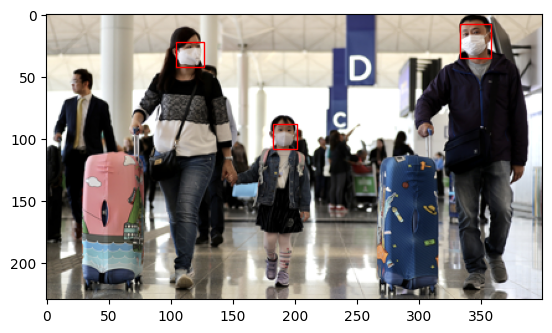

Target


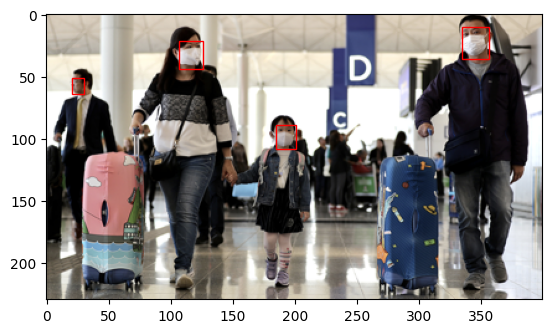

In [16]:
IMG_NUM = 4
print("Prediction")
plot_image(imgs[IMG_NUM], preds[IMG_NUM])
print("Target")
plot_image(imgs[IMG_NUM], annotations[IMG_NUM])

# SAVE MODEL

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/FaceMaskModel.pt')